# Quantization Troubleshooting with XQuant

This notebook demonstrates the process of generating an xquant report. The report provides valuable insights such as histograms and the similarity metrics between the original float model and the quantized model, which can be visualized using TensorBoard.

## Steps:
1. Load a pre-trained MobileNetV2 model and perform post-training quantization.
5. Define an xquant configuration.
6. Generate an xquant report to compare the float and quantized models.
7. Visualize the report using TensorBoard.

## Install

In [ ]:
!git clone https://github.com/reuvenperetz/model_optimization.git
!cd model_optimization && git checkout xquant
!pip install -r model_optimization/requirements.txt
!pip install -q torch torchvision

## Import necessary libraries

In [ ]:
import sys
sys.path.append('/content/model_optimization')
import model_compression_toolkit as mct
import numpy as np
from functools import partial
from xquant import XQuantConfig
import torch

## Define random data generator
For demonstration only, we will use a random dataset:

In [ ]:
# Function to generate random data. If use_labels is True, it yields data with labels;
# otherwise, it yields only data.
def random_data_gen(shape=(3, 224, 224), use_labels=False, batch_size=2, num_iter=2):
    if use_labels:
        for _ in range(num_iter):
            yield [[torch.randn(batch_size, *shape)], torch.randn(batch_size)]
    else:
        for _ in range(num_iter):
            yield [torch.randn(batch_size, *shape)]

## Quantize MobileNetV2

In [ ]:
# Load the pre-trained MobileNetV2 model and perform post-training quantization using
# the representative dataset generated by random_data_gen.
from torchvision.models.mobilenetv2 import MobileNetV2
float_model = MobileNetV2()
repr_dataset = random_data_gen
quantized_model, _ = mct.ptq.pytorch_post_training_quantization(in_module=float_model,
                                                                             representative_data_gen=repr_dataset)

## Generate report

In [ ]:
# Define the validation dataset and xquant configuration, including custom similarity metrics.
validation_dataset = partial(random_data_gen, use_labels=True)
xquant_config = XQuantConfig(report_dir='./logs', custom_similarity_metrics={'mae': lambda x,y: torch.nn.L1Loss()(x,y).item()})

# Generate the xquant report comparing the float model and the quantized model using the
# representative and validation datasets.
from xquant import xquant_report_pytorch_experimental
result = xquant_report_pytorch_experimental(
            float_model,
            quantized_model,
            repr_dataset,
            validation_dataset,
            xquant_config
        )

## Visualize in Tensorboard

In the tensorboard, one can find useful information like statistics of the float layers' outputs and the graph of the quantized model with similarities that were measured comparing to the float model. Currently, the similarity is measured at linear layers like Conv2d, Linear, etc. (may be changed in the future). When observing such node in the graph, the similarities can be found in the node's properties as 'xquant_repr' and 'xquant_val'.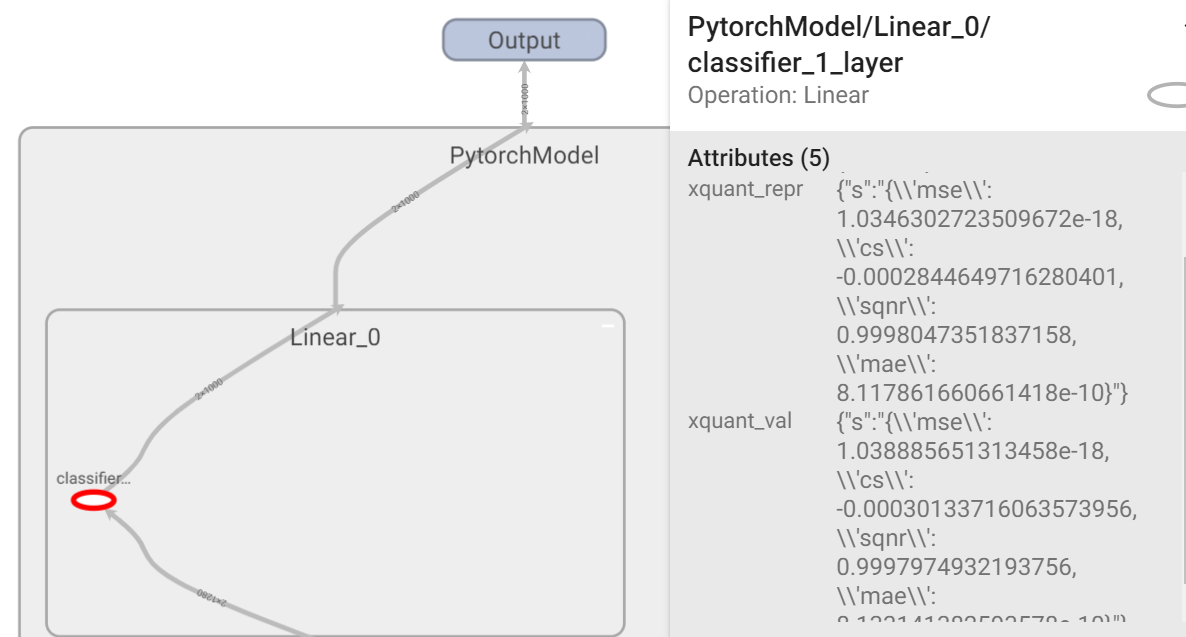

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs